# 3.2.1 How does the noise of the feedback affect the training ?

A few simulations to study how the noise of an explicit feedback affects the training of a simple Active Inference subject. 

In this simulation, the subject does not change its initial observation mapping and doesn't compute its associated novelty term when planning its new action.


In [7]:
# Make basic package imports
import numpy as np
import statistics as stat
import scipy.stats as scistats
import math,sys,os
import pickle 
import matplotlib.pyplot as plt

# Import actynf and the functions to help us plot the results
import actynf
from tools import simulate_and_save,extract_training_data # Saving and loading simulation outputs
from tools import dist_kl_dir # A tool to qualify subject learning
from tools import pointcloud_mean,clever_running_mean # Plot the mean + std of several points

from m1_model import neurofeedback_training # The Active Inference model we use

SAVING_FOLDER = os.path.join("..","..","simulation_outputs","paper1","3.2.1")
FIGURES_FOLDER = os.path.join("figures","3.2.1")


print("Results will be saved to " + SAVING_FOLDER + " (relative to this file)")

Results will be saved to ..\..\simulation_outputs\paper1\3.2.1 (relative to this file)


We use the m1_model as a basis for our simulations here. The m1_model has plenty of parameters but only some of them will be of interest to us to answer question 3.2.1.

In [8]:
def run_and_save_model(savepath,
        true_feedback_std,belief_feedback_std,
        Nsubj,Ntrials,
        overwrite=False):
    """
    Run a simulation of model m1 using the following parameters : 
    - savepath : where to store simulation outputs
    - true_feedback_std : wanted sigma_process value
    - belief_feedback_std : wanted sigma_model value for the feedback
    - Nsubj : subjects simulated for the simulations
    - Ntrials : how many trials simulated per subject (duration of the training)
    - overwrite : run simulations even if there exist results already ?
    """
    learn_a = False # In this first simulation, the subjects won't be questionning their feedback mappings

    T = 10
    Th = 2
    feedback_resolution = 5 # No

    subj_cognitive_resolution = 5 # Ns (model)
    true_cognitive_resolution = 5 # Ns (process)

    k1b = 0.01   # Initial action mapping weight
    epsilon_b = 1.0

    k1a = 10     # Initial feedback mapping weight (model)
    epsilon_a = 0.0/101.0   # Added uniform distribution weight added
        # a0 is defined as = norm(epsilon_a* ones + gaussian_prior)*k1a

    k1d = 1.0   # Initial starting state mapping weight (model)
    epsilon_d = 1.0  # Added uniform distribution weight added
        # d0 is defined as = norm(epsilon_d* ones + [1,1,0,0,0])*k1d   [for Ns=5]
    
    neutral_action_prop = 0.2 # 20% of the actions have no effect on the subject cognitive state

    pRest = 0.5   # Without any increasing action, there is a pRest chance that the cognitive state will decrease spontaneously
    pEffect  = 0.99   # An adequate action will increase the subject mental state with a probability pEffect

    action_selection_inverse_temp = 32.0 # How much noise in the selection of actions after EFE calculation
    
    net = neurofeedback_training(T,Th,  # Trial duration + temporal horizon
            subj_cognitive_resolution,true_cognitive_resolution,       # Subject belief about cognitive resolution / true cognitive resolution
            feedback_resolution,feedback_resolution,       # Subject belief about feedback resolution / true feedback resolution
            belief_feedback_std,true_feedback_std,   # Subject belief about feedback noise / true feedback noise
            neutral_action_prop,       # how many actions have no impact on the state ?
            k1b,epsilon_b,  # Action mapping previous knowledge
            k1a,epsilon_a,   # Feedback mapping previous knowledge
            k1d,epsilon_d,   # d mapping previous knowledge
            pRest,pEffect,   # How likely it is that the cognitive state will go down when unattended
                        # / how likely it is that the correct action will increase the cognitive state
            clamp_gaussian=False,asit = action_selection_inverse_temp,
            learn_a=learn_a) 
                        # Clamp : Weither to increase the categorical probabilistic weights
                        # on the edges or not
                        # asit : inverse temperature of the action selection process
                        # learn_a : Weither to learn the perception matrix on the go                                       

    simulate_and_save(net,savepath,Nsubj,Ntrials,override=overwrite)



## 1. Simulation 1

**Simulation 1 :** Let's run the model for a perfect feedback ($\sigma_{process} = 0.01$) and a very high expected feedback quality ($\sigma_{model} = 0.01$) :

In [9]:
savepath = os.path.join(SAVING_FOLDER,"simulation1")

sigma_model = 0.01
sigma_process = 0.01

N_subj = 10     # How many different subjects are simulated
N_trials = 30   # How long each of those subjects will train

run_and_save_model(savepath,sigma_process,sigma_model,N_subj,N_trials)

We can then use the saved results to plot the training procedure :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


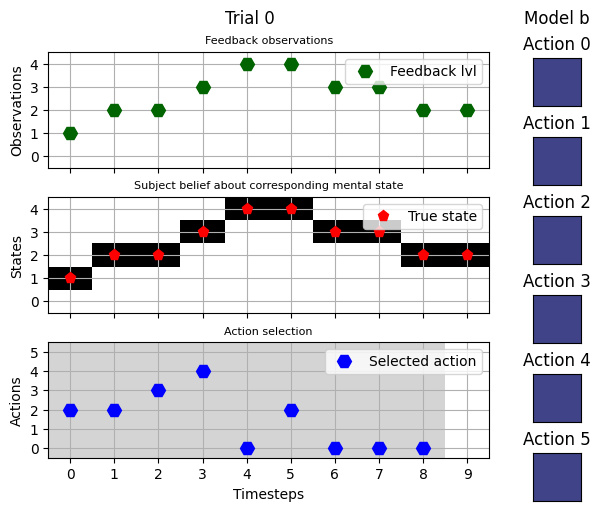

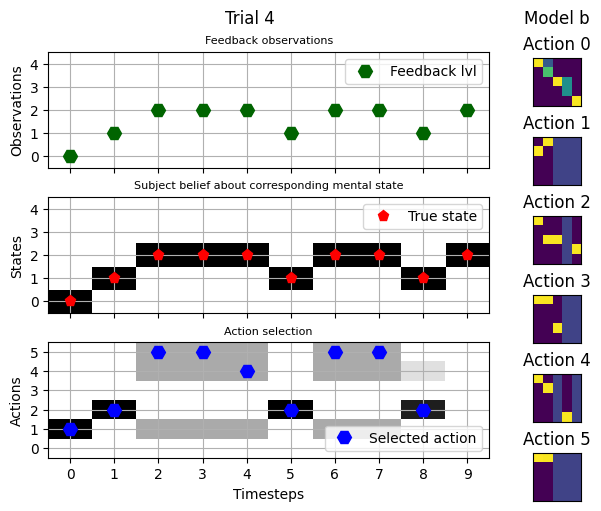

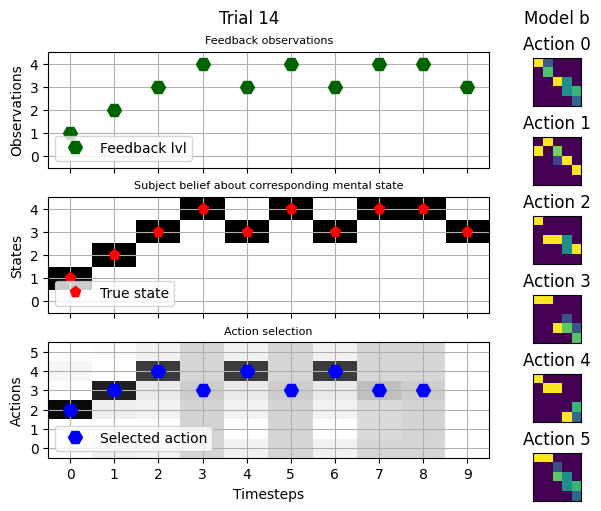

In [10]:
from tools_trial_plots import plot_one_trial

saved_data_path = os.path.join(SAVING_FOLDER,"simulation1")
_stm,_weight,_Nsubj,_Ntrials = extract_training_data(saved_data_path)
# stm : short term memories : the hidden states, observation, action and subject inferences for a specific trial 
# (starting from 1 to Ntrials)
# weights : the weights of the subject models for a given trial
# (starting from 0[before training] to Ntrials)

subject = 4 # What subject are we studying ?
plot_these_trials = [0,4,14]
for trial in (plot_these_trials):
    plot_one_trial(_stm,_weight,subject,trial,"Trial " + str(trial),
                   save_fig_path=os.path.join(FIGURES_FOLDER,"sim1"),
                   name="trial_"+str(trial)+".png")                 

As expected, the subjects manage to quickly figure out an adequate path and an adequate action model. Although those results are interesting to understand how each observation individually affected the model of the subject, it's pretty difficult to use it to conclude on the broader training. Let's plot the results for a wider range of subjects : 

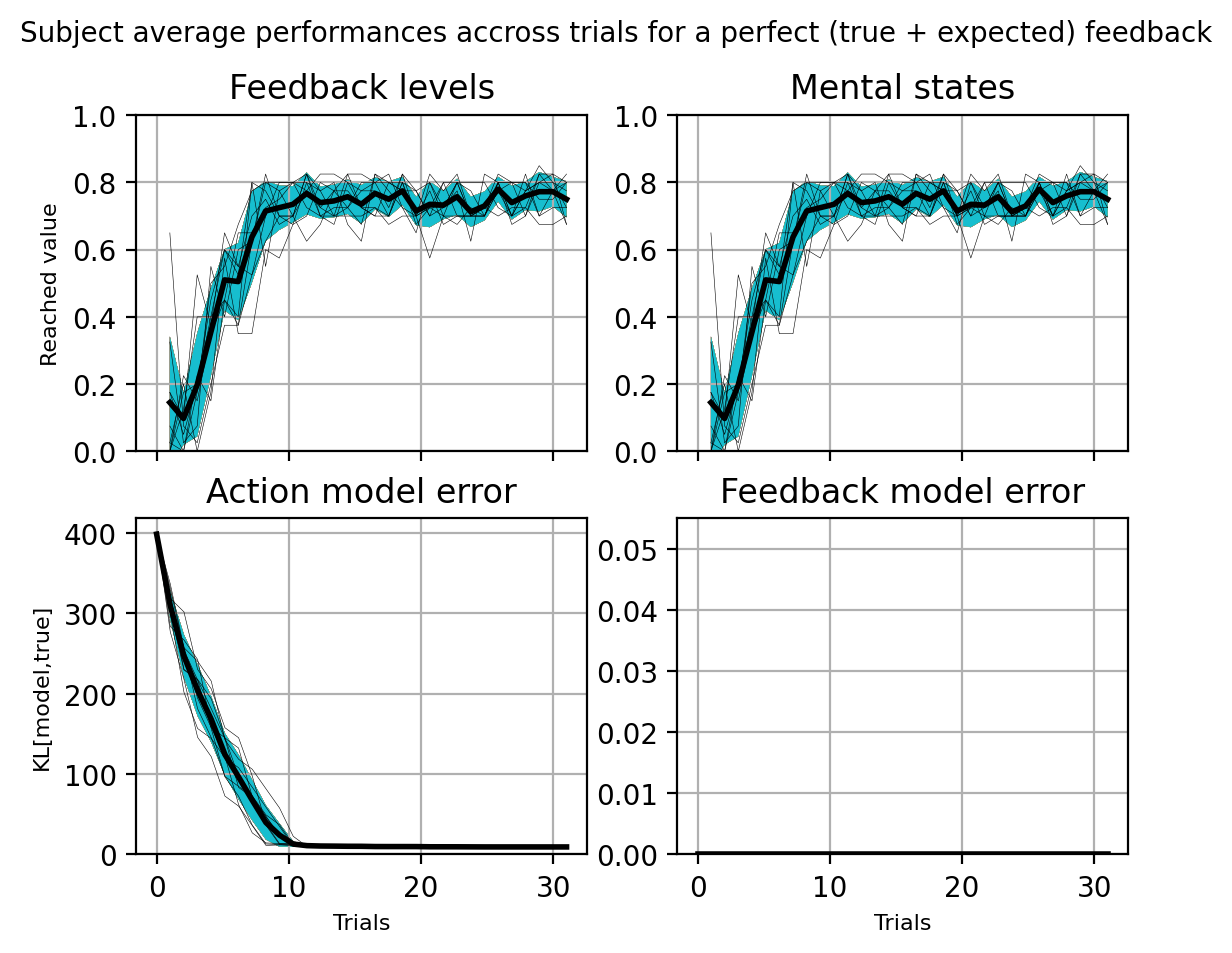

In [15]:
from tools_trial_plots import plot_training_curve

saved_data_path = os.path.join(SAVING_FOLDER,"simulation1")
_stm,_weight,_Nsubj,_Ntrials = extract_training_data(saved_data_path)
figure = plot_training_curve(_stm,_weight,"Subject average performances accross trials for a perfect (true + expected) feedback",
                save_fig_path=os.path.join(FIGURES_FOLDER,"sim1"),
                name="training_curve.png")



## 2. Simulation 2

**Simulation 2 :** Let's run the model for a similar set of subject feedback expectations ($\sigma_{model} = 0.01$) but a lower true feedback quality ($\sigma_{process} = 0.5$) :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


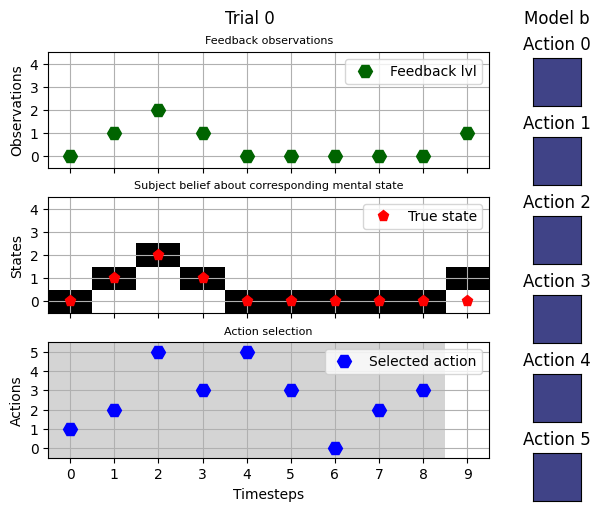

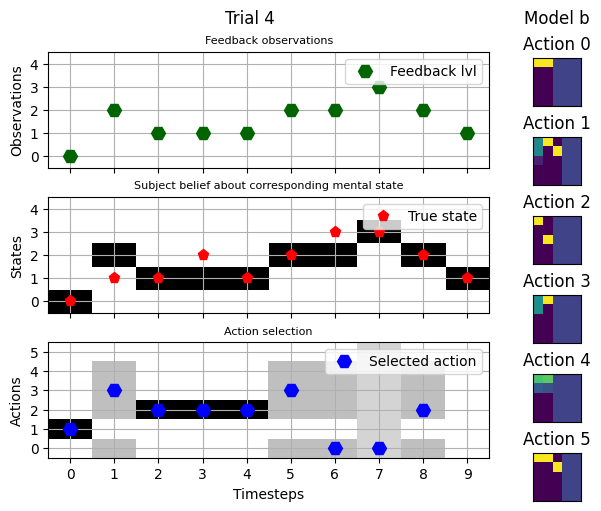

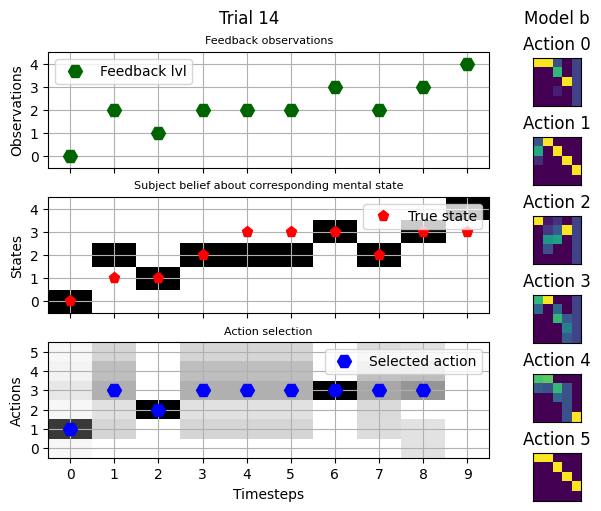

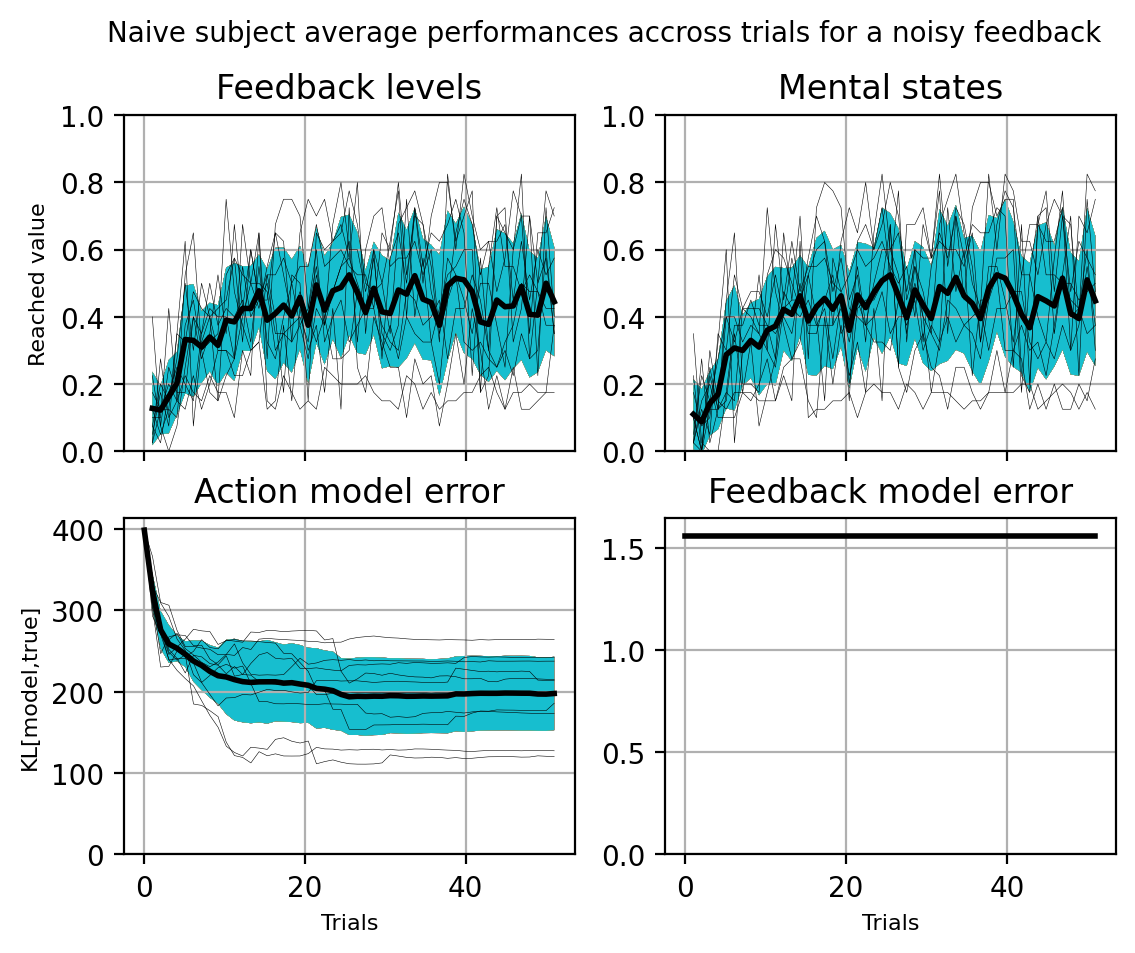

In [16]:
savepath = os.path.join(SAVING_FOLDER,"simulation2")

sigma_model = 0.01
sigma_process = 0.5

N_subj = 10
N_trials = 50

run_and_save_model(savepath,sigma_process,sigma_model,N_subj,N_trials)

# -----------------------------------------------------------------------------------------
# EXPLOIT THE DATA WE JUST SAVED 
# -----------------------------------------------------------------------------------------
saved_data_path = os.path.join(SAVING_FOLDER,"simulation2")
_stm,_weight,_Nsubj,_Ntrials = extract_training_data(saved_data_path)

subject = 4 # What subject are we studying ?
plot_these_trials = [0,4,14]
for trial in (plot_these_trials):
    plot_one_trial(_stm,_weight,subject,trial,"Trial " + str(trial),
                   save_fig_path=os.path.join(FIGURES_FOLDER,"sim2"),
                   name="trial_"+str(trial)+".png")     

fig = plot_training_curve(_stm,_weight,"Naive subject average performances accross trials for a noisy feedback",
                save_fig_path=os.path.join(FIGURES_FOLDER,"sim2"),
                name="training_curve.png")


As expected, increasing the noise of the true feedback (i.e. decreasing its quality) leads to :
- A lower overall feedback achieved by the participants
- Lowered the cognitive performances of the subject : it was less effective to teach subjects how to self-regulate.
- A longer training period (it took longer to reach the optimal cognitive state)
- A wider range of behaviour (some subjects had luck, others less so !)

We play the same simulation with **a lot** of noise ($\sigma_{process} = 1.0$) :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


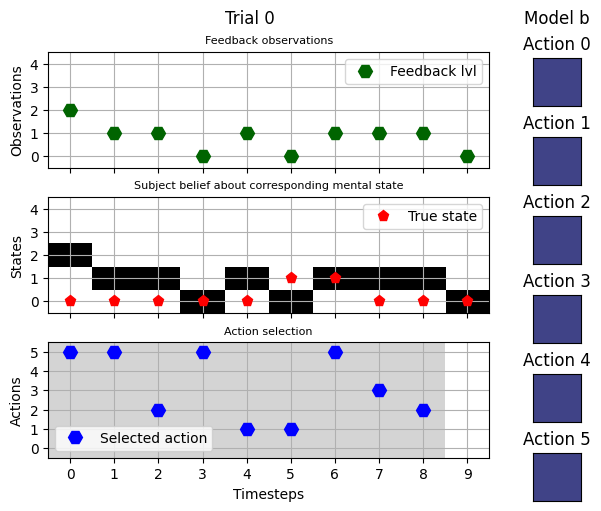

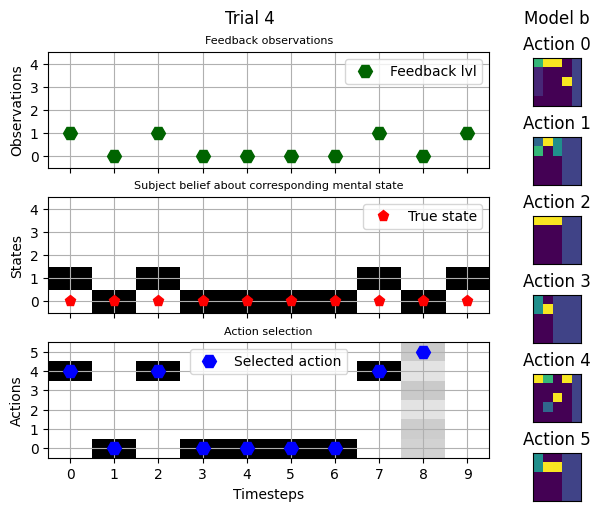

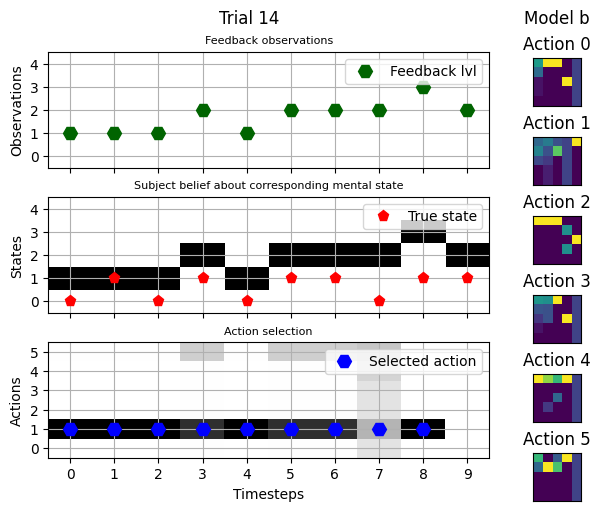

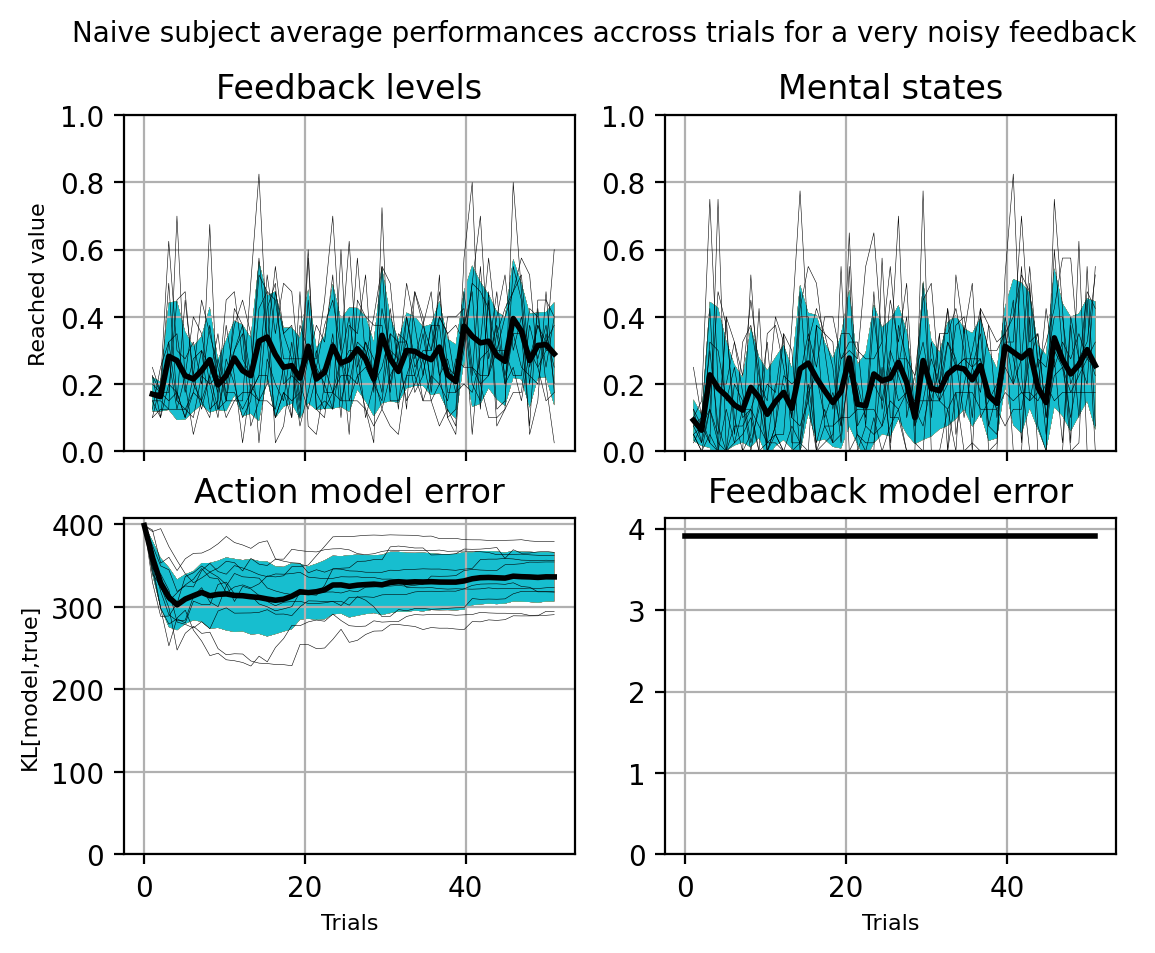

In [17]:
savepath = os.path.join(SAVING_FOLDER,"simulation3")

sigma_model = 0.01
sigma_process = 1.0

N_subj = 10
N_trials = 50

run_and_save_model(savepath,sigma_process,sigma_model,N_subj,N_trials)

# -----------------------------------------------------------------------------------------
# EXPLOIT THE DATA WE JUST SAVED 
# -----------------------------------------------------------------------------------------
saved_data_path = os.path.join(SAVING_FOLDER,"simulation3")
_stm,_weight,_Nsubj,_Ntrials = extract_training_data(saved_data_path)

subject = 4 # What subject are we studying ?
plot_these_trials = [0,4,14]
for trial in (plot_these_trials):
    plot_one_trial(_stm,_weight,subject,trial,"Trial " + str(trial),
                   save_fig_path=os.path.join(FIGURES_FOLDER,"sim3"),
                   name="trial_"+str(trial)+".png")     

fig = plot_training_curve(_stm,_weight,"Naive subject average performances accross trials for a very noisy feedback",
                save_fig_path=os.path.join(FIGURES_FOLDER,"sim3"),
                name="training_curve.png")

When the feedback is too noisy, the ability of the subject to learn from it is greatly diminished. In that last simulation, the subject very marginally increased its trained mental state by the end of the training. 
Interestingly, the quality of the action model of the subject increases in the first 10 trials, but worsens with more trials in the remaining 40. 

## 4. Analysis of biomarker noise on Neurofeedback Training outcome

Basing ourselves on the previous simulations, we plot the training of subjects training with feedbacks of varying qualities. We selected the true feedabck noise randomly between $\sigma_{process} = 0.01$ (perfect feedback) and $\sigma_{process} = 2.5$ (sham feedback). We plotted the average cognitive state reached by the subjects in the last 20 trials as well as the quality of their aciton model depending on that process noise. 

For all data points, the subject expected the feedback to be perfect ($\sigma_{model} = 0.01$) and did **not** update this belief during training. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


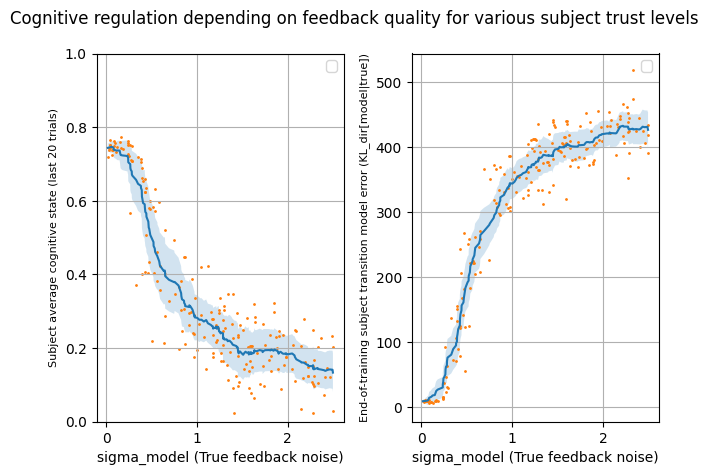

In [19]:
def plot_training_outcome_vs_feedback_noise(_savespath):
    trialsLastN = 20
    
    # Common plots
    fig,axes = plt.subplots(1,2,dpi=100)
    fig.suptitle("Cognitive regulation depending on feedback quality for various subject trust levels")
    ax  = axes[0]
    ax_act = axes[1]
    ax.grid()
    ax_act.grid()
    
    ax.set_ylim([0.0,1.0])
    # ax_act.set_ylim(bottom=0.0)

    ax.set_xlabel("sigma_model (True feedback noise)")
    ax_act.set_xlabel("sigma_model (True feedback noise)")

    ax.set_ylabel("Subject average cognitive state (last " + str(trialsLastN) + " trials)",fontsize=8)
    ax_act.set_ylabel("End-of-training subject transition model error (KL_dir[model|true])",fontsize=8)

    onlyfiles = [os.path.join(_savespath, f) for f in os.listdir(_savespath) if os.path.isfile(os.path.join(_savespath, f))]

    xs = []
    ys = []
    zs = []
    for file in onlyfiles:
        filename = os.path.basename(file)

        true_fb_std = float(filename)

        _stm,_weight,_Nsubj,_Ntrials = extract_training_data(file)

        state_perfs = [_stm[0][idx][0].x[0] for idx in range(1,_Ntrials+1)]
        action_model = [dist_kl_dir(_weight[0][idx][1]["b"][0],_weight[0][idx][0]["b"][0]) for idx in range(1,_Ntrials+1)]
        state_perfs_array = np.array(state_perfs)
        action_model_array = np.array(action_model)
        
        xs.append(true_fb_std) 
        ys.append(np.mean(state_perfs_array[-trialsLastN:,:])/(_stm[0][1][0].x_d.shape[0]-1)) # Score / number of state to get a result between 0 and 1
        zs.append(action_model_array[-1])
        
    X,Y,vY = pointcloud_mean(xs,ys,30)
    X,Z,vZ = pointcloud_mean(xs,zs,30)                
    
    ax.fill_between(X,Y-vY,Y+vY,alpha=0.2)
    ax.scatter(xs,ys,s=1)
    ax.plot(X,Y)
    
    ax_act.fill_between(X,Z-vZ,Z+vZ,alpha=0.2)
    ax_act.scatter(xs,zs,s=1)
    ax_act.plot(X,Z)

    ax.legend()
    ax_act.legend()

    fig.tight_layout()

    return fig
    fig.show()
    input()


savepath = os.path.join(SAVING_FOLDER,"simulation4")

NPoints = 200
Nsubj_per_point = 1
N_trials = 100

sigma_model = 0.01

DIR = savepath
if not os.path.exists(DIR):
    os.makedirs(DIR)

k = len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])
while k<NPoints:
    print()
    print("POINT " + str(k+1) + " / " + str(NPoints))
    print()
    
    # Let's pick a random feedback noise value between 0 and 2.5 ! 
    sigma_process = np.random.uniform(0.01,2.50)
    sim_savepath = os.path.join(savepath,"{:10.4f}".format(sigma_process))
    
    run_and_save_model(sim_savepath,
        sigma_process,sigma_model,
        Nsubj_per_point,N_trials,
        overwrite=False)

    k = len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])


figure = plot_training_outcome_vs_feedback_noise(savepath)
figure.savefig(os.path.join(FIGURES_FOLDER,"biomarker_noise.png"))